In [1]:
from IPython.display import Image

Reference: [https://arxiv.org/abs/1612.03242](https://arxiv.org/abs/1612.03242), [https://github.com/hanzhanggit/StackGAN](https://github.com/hanzhanggit/StackGAN)

Generative Adversarial Network는 생성모델 중 하나로 Goodfellow가 발표한 이후 굉장히 많이 연구되고 있다. 활발히 연구되고 있는 분야들 중 하나는 텍스트로부터 이미지를 만들어내는 것인데 현재의 모델들은 모두 '표현'만 가능할 뿐 세세한 정보를 담아내지 못하는 문제점이 있다. 글로부터 이미지를 만들어내는 모델들 중 conditional GAN은 이미 글의 의미를 담은 이미지를 생성할 수 있다. 하지만 자세한 의미를 포함하지 않거나 낮은 해상도의 이미지만 생성할 수 있다는 단점이 있다. 해상도 문제를 해결하기 위해 단순히 upsampling layer만 추가하다보면, 학습과정이 불안정해진다. upsampling에 대한 설명은 [여기](https://zzsza.github.io/data/2018/06/25/upsampling-with-transposed-convolution/#convolution-%EC%97%B0%EC%82%B0)에 있으며, 쉽게 말해 낮은 차원의 벡터를 높은 차원의 벡터로 만들어주는 것이다.GAN으로 고해상도의 이미지를 만드는 것이 어려운 이유 중 하나는 실제 이미지의 distribution과 적용된 모델의 distribution이 고차원의 픽셀 공간에서는 겹치지 않을 수 있다는 것이고 이 문제는 목표 해상도가 높아질 수록 더 심해진다. 이러한 문제를 해결하기 위해, 논문에서는 텍스트에서 이미지를 만들어내는 과정을, 글로부터 대략적인 이미지 구성과 색을 얻어낸 후 그 결과와 글을 사용하여 오류를 고치고, 더 높은 화질의 이미지를 얻어내는 **두 단계의 GAN으로 구성된 sketch-refinement** 방식을 고안하였다. 또한, 하나의 글로부터 다양한 결과 이미지를 얻어내고, 학습과정을 안정화시키기 위해 **Conditioning Augmentation** 기술을 적용시켰다. StackGAN은 두 단계의 GAN으로 구성되어 있는데 첫 번째는 텍스트를 input으로 받아 대략적인 이미지의 구성과 색을 output으로 내놓는 **Stage-I GAN**, 두 번째는 Stage-I GAN의 output과 텍스트를 input으로 받아 더 많은 정보와 높은 해상도의 이미지를 output으로 내놓는 **Stage-II GAN**이다. **Conditioning Augmentation** 기술은 학습을 할 때 글-이미지 쌍이 충분하지 않아 text conditioning manifold의 빈 공간이 생기는 경우 latent conditioning manifold를 잘 이어주기 위한 방법이다. 이 기술은 conditioning manifold에 랜덤한 변형을 야기하여 합성된 이미지들이 다양해지도록 한다. 논문에서 새로 만들어 제안한 방법은 정리하여 크게 세 가지이다.
1. Stacked Generative Adversarial Network
2. Conditioning Augmentation Technique
3. Extensive Qualitative and Quantitative Experiments

## Method
이제 모델의 아키텍쳐에 대해 좀 더 알아보자. StackGAN은 두 가지의 GAN으로 구성되어 있다.
1. Stage-I GAN  
    이미지의 구성과 색을 주어진 글의 내용에 따라 구성하고, 랜덤 노이즈 벡터로부터 배경을 그리면서 낮은 해상도의 이미지를 1차적으로 얻어낸다.  
2. Stage-II GAN  
    Stage-I GAN의 저해상도 이미지의 부족한 부분을 보충해주고, 다시 한 번 글을 input으로 받으면서 글의 내용 중 빠진 부분이 있으면 보충해주는 것과 동시에 높은 해상도의 이미지를 만들어낸다.  

### 1. Preliminaries
기본적으로 generator와 discriminator가 adversarial한 경쟁을 하면서 학습되는 Generative Adversarial Network(GAN)이 배경이 된다. 이론적으로, GAN은 random noise가 geneerator를 거치면서 만들어지는 벡터와 실제 벡터를 구분하는 discriminator를 먼저 학습시키면서 discriminator가 실제 벡터가 가지는 정보들을 내포하도록 만든 다음, 완벽한 discriminator가 만들어졌다는 가정하에 그것을 그대로 적용시킨 상태에서 generator를 discriminator가 내포한 실제 벡터의 정보대로 벡터를 만들 수 있도록 학습시킨다. 목적 함수는 아래와 같다.
$$min_G max_D V(D,G) = \mathbb{E}_{x \sim p_{data}}[log(D(x))] + \mathbb{E}_{z \sim p_z}[log(1-D(G(z))]$$
$x$는 실제 데이터 분포 $p_{data}$로부터 샘플링된 실제 이미지이고, $z$는 노이즈 벡터로 $p_z$라는 분포로부터 샘플링된 것이다. 즉 discriminator가 완벽하게 학습되었다면, 실제 이미지에 대해서는 1, 가짜 이미지에 대해서는 0의 값을 내야 하기 때문에 목적 함수의 값이 $log 1+ log 1 = 0$의 최대값을 가질 것이고, discriminator가 완벽하다는 가정 하에 generator가 완벽하게 학습되었다면 $log 1 + log 0 = -\inf$으로 목적 함수가 최소값을 가질 것이다.  
Conditional GAN은 GAN의 확장판으로 generator와 discriminator가 모두 추가적인 conditioning vaiable $c$를 input으로 받아들이게 되고 결과적으로 $G(z,c), D(x,c)$를 학습시키는 것이다. 결과적으로 $D(x,c)$를 잘 속일수 있을 정도로 실제 데이터 $X$의 정보와 condition에 대한 정보 $c$를 잘 포함하는 $G$를 만들게 되는 것이다.

### 2. Conditioning Augmentaiton
이전에 나온 [conditional GAN](https://arxiv.org/abs/1605.05396)의 아키텍쳐는 아래의 그림과 같다.

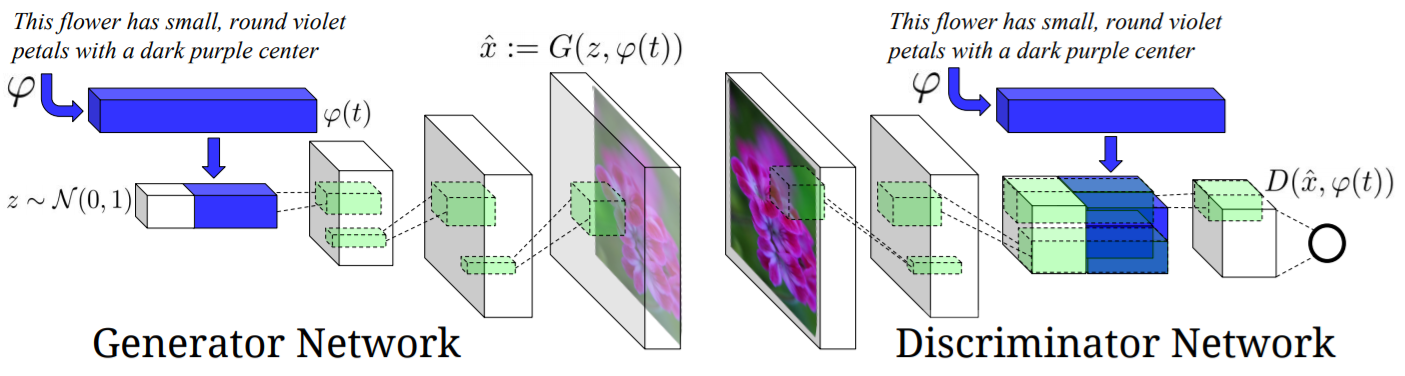

In [2]:
Image(filename = 'ConditionalGAN.PNG')

텍스트 정보를 $\varphi$로 embedding시키고 그것과 노이즈 벡터 $z$를 concat시킨 다음 upsampling을 통해서 가짜 이미지를 만들어내고 discriminator를 학습 시킨 후 generator를 학습시키는 방법이다. 이런 식으로 학습을 시킬 경우 일반적으로 텍스트 embedding의 latent space는 고차원이기 때문에 한정된 데이터로는 latent space에 불연속성이 생길 수 밖에 없다. 이를 해결하기 위해 고안된 방법이 Conditioning Augmentation이다.이 방법은 추가적으로 conditioning variable $\widehat{c}$를 만든다. 위에서 언급한 것처럼 고정된 텍스트 embedding을 사용하는 것이 아니라, 랜덤 latent variable $\widehat{c}$를 독립적인 가우시안 분포 $N(\mu(\varphi_t), \Sigma(\varphi_t))$로부터 만들어서 사용한다. 이 때 가우시안 분포의 성분들은 모두 텍스트 embedding $\varphi_t$에 대한 함수이다. 이 방법은 적은 수의 이미지-텍스트 쌍으로부터 더 많은 학습용 이미지-텍스트 쌍을 만들어낼 수 있고 이는 텍스트 embedding의 latent space가 더 연속적으로 만들어지는 것을 의미한다.  
뿐만 아니라, overfitting을 없애고 latent space가 더 연속적으로 만들어지도록 하기 위해, KL divergence를 사용한 regularization 항을 추가해준다. 식은 아래와 같다.
$$D_{KL} (N(\mu(\varphi_t), \Sigma(\varphi_t))||N(0, I))$$
논문의 깃허브에서 kl loss를 generator loss와 더하여 학습시키는 것으로 보아 randomness를 나타내는 standard gaussian distribution과 conditioning gaussian distribution을 비슷하게 만들어주는 것으로 보인다.

### 3. Stage-I GAN
계속해서 언급했던 것처럼, Stage-I GAN은 텍스트를 input으로 받아 낮은 해상도의 적은 정보를 포함한 이미지를 만들어낸다. 우선 pre-trained encoder를 통해 $\varphi_t$라는 텍스트 embedding을 만들어낸다. Embedding의 condition은 fully connected layer를 통해 $N(\mu(\varphi_t), \Sigma(\varphi_t))$라는 gaussian distribution으로부터 샘플링된 $\widehat{c}_0$라는 gaussian conditioning variable로 표현된다. Stage-I GAN은 discriminator의 loss ${L_D}_0$를 최대화시키고, generator의 loss ${L_G}_0$을 최소화시키면서 학습된다. Discriminator와 Generator의 loss 식들은 아래와 같다.
$${L_D}_0 = \mathbb{E}_{(I_0, t) \sim p_{data}} [log(D_0(I_0, \varphi_t)] + \mathbb{E}_{z \sim p_z, t \sim p_{data}} [log(1-D_0(G_0(z, \widehat{c}_0), \varphi_t)]$$
$${L_G}_0 = \mathbb{E}_{z \sim p_z, t \sim p_{data}} [log(1-D_0(G_0(z, \widehat{c}_0), \varphi_t)] + \lambda D_{KL} (N(\mu(\varphi_t), \Sigma(\varphi_t))||N(0, I))$$
식에서 $I_0$는 실제 이미지이고, $t$는 실제 데이터 분포인 $p_{data}$로부터 샘플링된 것들이고 ,$z$는 노이즈 벡터로 $p_z$라는 분포로부터 샘플링된 것이다. $\lambda$는 regularization parameter로 KL항과 vanilla GAN의 generator loss항을 조율시켜주며 실험에서는 그 값으로 1을 사용하였다.  
식을 천천히 훑어보면, discriminator의 경우 vanilla GAN의 loss와 동일한 구조임을 알 수 있고, condition에 대한 정보를 담은 $\widehat{c}_0$항이 generator를 통해 이미지가 만들어질 때나 discriminator가 진짜 이미지를 판단할 때 추가된 것을 알 수 있다. Generator의 경우도 마찬가지로 vanilla GAN에 condition 부분만 추가된 항이 있지만, 더불어 condition latent space의 연속성을 추가하기 위에 전에 언급하였던 KL divergence 항 또한 추가되었다.

### 4. Stage-II GAN
낮은 해상도의 Stage-I GAN의 결과 이미지($s_0 = G_0(z, \widehat{c}_0)$)와 gaussian conditioning variable($\widehat{c}$)로부터 더 높은 해상도의 결과를 만들어내는 Stage-II GAN의 loss는 Stage-I GAN의 loss와 거의 같은 구조이다. 식은 아래와 같다.
$${L_D} = \mathbb{E}_{(I, t) \sim p_{data}} [log(D_0(I, \varphi_t)] + \mathbb{E}_{s_0 \sim {p_G}_0, t \sim p_{data}} [log(1-D(G(s_0, \widehat{c}), \varphi_t)]$$
$${L_G} = \mathbb{E}_{s_0 \sim {p_G}_0, t \sim p_{data}} [log(1-D(G(s_0, \widehat{c}), \varphi_t)] + \lambda D_{KL} (N(\mu(\varphi_t), \Sigma(\varphi_t))||N(0, I))$$
Generator에 랜덤 노이즈 벡터 $z$를 사용하지 않은 것은 $s_0$가 만들어지는 과정에서 이미 랜덤한 요소가 추가되었기 때문이다. 또한, gaussian conditioning variable $\widehat{c}$는 Stage-I GAN에 사용되었던 $\widehat{c}_0$와 같은 pre-trained encoder를 거친 같은 텍스트 embedding에서 Stage-I GAN과 다른 fc layer를 사용하여 샘플링된다. 즉 $(\mu_0, \sigma_0), (\mu, \sigma)$는 다른 값을 가진다.

### 5. Implementaiton Details
실제 StackGAN의 아키텍처는 아래의 그림에 나와있다.

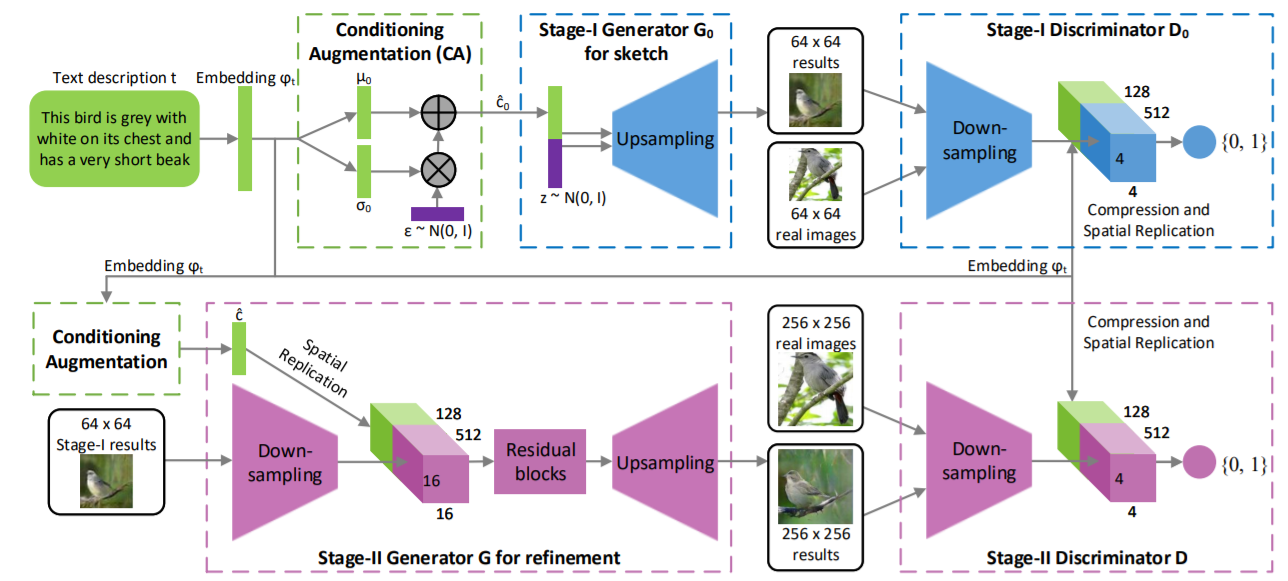

In [3]:
Image(filename = 'StackGAN.PNG')

윗부분이 Stage-I GAN, 아랫부분이 Stage-II GAN이다.
1. Stage-I GAN
    - Generator($G_0$)
        텍스트 embedding $\varphi_t$를 fully connected layer를 거쳐 gaussian distribution $N(\mu(\varphi_t), \Sigma(\varphi_t))$의 $\mu_0, \sigma_0$를 얻어낸 후, reparamitization trick $\mu_0 + \sigma_0 \odot \epsilon$을 사용하여 $N_g$ 차원의 conditioning vector $\widehat{c}_0$을 얻어낸다($\epsilon$은 standard gaussian distribution으로부터 샘플링된 랜덤 벡터이다). 만들어진 것과 $N_z$차원의 노이즈를 concat시킨 후 upsampling을 통해서 $W_0 \times H_0$ 크기의 이미지를 만들어낸다.
    - Discriminator($D_0$)
        $G_0$로부터 만들어진 이미지를 $M_d \times M_d$차원으로 downsampling시키고, 텍스트 embedding을 $N_d$차원으로 압축시킨 뒤에 $M_d \times M_d \times N_d$차원으로 spatially replicated된다. 이 두개의 벡터를 이미지의 channel dimension($Width \times Height \times Channel$)으로 concat시킨다. 그 후 $1\times1$ 크기의 convolution layer를 통과한 다음 fc layer를 통과하여 0과 1 사이 값을 가지는 점수가 나온다.

2. Stage-II GAN
    - Generator($G$
        두 번째 GAN은 첫 번째 GAN의 결과물 이미지를 input으로 받는다. 따라서 이미지를 재해석하여 생성하는 autoencoder와 같은 encoder-decoder구조를 가진다. 우선, 텍스트 embedding $\varphi_t$가 Stage-I GAN과는 다른 fc layer를 거쳐 $\mu, \sigma$가 나온다. Reparamitization trick을 사용하여 새로운 $N_g$차원의 conditioning vector $\widehat{c}$를 만들고 이를 $M_g\times  M_g\times N_g$차원으로 spatially replicate시킨다. 그것과 동시에 Stage-I GAN의 결과 $s_0$를 downsampling하여 $M_g \times M_g$ 크기의 벡터를 만들어 두 가지 벡터를 concat시킨 다음, residual block을 거치고, upsampling을 하여 $W\times H$ 크기를 가진 높은 해상도의 이미지를 만들어낸다.
    - Discriminator($D$)
        Stage-II GAN의 discriminator는 Stage-I GAN의 그것과 비슷하지만, 이미지의 해상도가 좀 더 높아짐에 따라 downsampling block이 하나 더 추가된 구조이다.
        
3. Matching-Aware Discriminator
    [이 논문](https://arxiv.org/pdf/1605.05396)에 따르면, Vanilla GAN의 discriminator는 condition에 대한 정보가 담긴 벡터를 무시하고, 처음 학습을 시작할 때 generator로부터 만들어진 샘플들을 모두 거부한다. 따라서 conditional GAN에서의 discriminator에서는 generator가 만든 것이 condition을 만족하는지에 대한 정보도 구분할 수 있어야 한다. Naive GAN discriminator에서는 실제 이미지와 그에 해당하는 텍스트, 합성된 이미지와 임의의 텍스트 두 종류의 input을 통해 텍스트와 맞지 않는 실제 이미지, 특정 텍스트에 대해 비현실적인 이미지 두 가지의 에러를 줄여 나간다. 앞서 언급한 문제를 해결하기 위해서, 이미지와 텍스트가 올바르게 연결되어 있는지를 판단해야 하기 때문에 실제 이미지와 맞지 않는 텍스트를 input으로 추가하여 이미지와 텍스트의 연관성을 판별하는 것을 학습시킨다. 이를 통해 discriminator는 generator에게 텍스트에 해당하는 이미지를 생성하는데 있어 도움 되는 추가적인 신호를 보낼 수 있다.

## Experiments
GAN-INT-CLS, GAWWN이라는 state-of-the-art수준의 텍스트-이미지 생성 GAN모델들과 비교하고, StackGAN에서 도입한 것들이 얼마나 좋은 영향을 미치는지 판단하기 위해 세 가지를 살펴보았다.
1. Conditioning Augmentation, Stacked structure의 영향이 얼마나 좋은지
    이를 판단하기 위해 64$\times$64 256$\times$256 크기의 이미지를 만들도록 Stage-I GAN을 직접적으로 학습시켰다.
2. StackGAN이 큰 사이즈의 이미지에서 더 좋은 화질을 만드는지
    이를 판단하기 위해 128$\times$128, 256$\times$256 크기의 이미지들을 만들어 비교해보았다.
3. 텍스트를 두 stage에 모두 넣는 것이 좋은지  

데이터셋으로는 CUB, oxford-102, MS COCO를 사용하였다. 모두 새에 관한 이미지이고, pre-processing을 통해 모든 이미지에서 새가 차지하는 영역의 비율이 0.75를 넘도록 하였다. 이 중에서는 다양한 배경과 많은 물체들이 이미지에 등장하는 MS-COCO가 가장 어려운 task이고 하나의 이미지에 대한 5개의 표현이 있다. CUB와 oxford-102는 하나의 이미지에 대한 10개의 표현이 있다.  

GAN은 대부분 결과물이 좋지만 결과물을 평가하는 것이 어렵다. 논문에서는 [이 논문](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans)에서 언급된 inception score를 정량적인 평가를 위해 도입하였다. Inception score를 간단히 설명하자면, $x$가 만들어진 샘플이고 $y$가 inception model로부터 예측된 라벨이라고 하였을 때, 좋은 generator일 경우 더 다양한 이미지를 생성하여 $p(y)$의 entropy가 높을 것이고, 특정 condition을 포함하는 이미지들은 그 latent distribution $p(y|x)$가 낮은 entropy를 가질 것이라는 생각에서부터 출발하여 아래와 같은 식을 유도하였다.
$$I = exp(\mathbb{E}_x D_{KL} (p(y|x)||p(y))) = exp(\mathbb{E}_x \mathbb{E}_{p(x|y)} [log(\frac{p(x|y)}{p(y)}]$$
좋은 generator일 수록 분자의 값은 크고, 분모의 값은 작아져서 $I$의 값이 커지게 된다. 하지만 inception score는 이미지가 잘 만들어졌는지에 대한 내용만 평가할 수 있고, 이미지와 텍스트가 대응되는 정도는 수치적으로 값을 매기지 못하기 때문에 10명의 사람들의 평가를 통해 그 값을 매겼다.

## Results

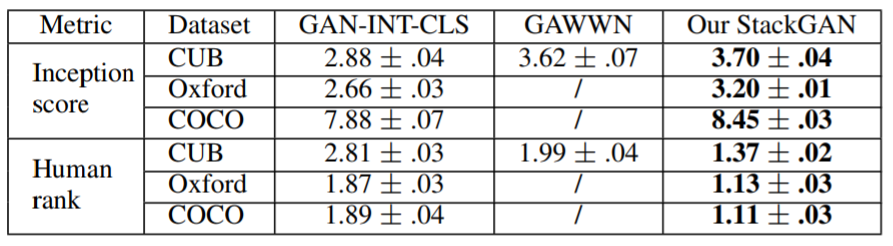

In [5]:
Image(filename = 'StackGAN_table1.PNG')

위의 표에서 결과값들을 비교할 수 있다. 표의 값들에서 바로 알 수 있듯이, 모든 데이터셋에 대해서 StackGAN이 다른 두 개의 모델에 비해 더 좋은 성능을 보인다. 실제로 만들어진 사진들을 봐도 다른 모델들은 새의 다리나 부리 부분에 대한 내용이 정확하지 않게 표현되는 경우가 많은 반면, StackGAN은 정확하게 자세한 부분들까지 모두 만들어냈다. 결과적으로, StackGAN만이 텍스트에 있는 모든 정보들을 포함하면서 높은 해상도를 가지는 256$\times$256 크기의 이미지를 만들어낼 수 있었다. 또한, Stage-I GAN과 Stage-II GAN의 이미지들을 비교해보면서, Stage-II GAN이 Stage-I GAN의 결과들을 수정한다는 것을 알 수 있었다.

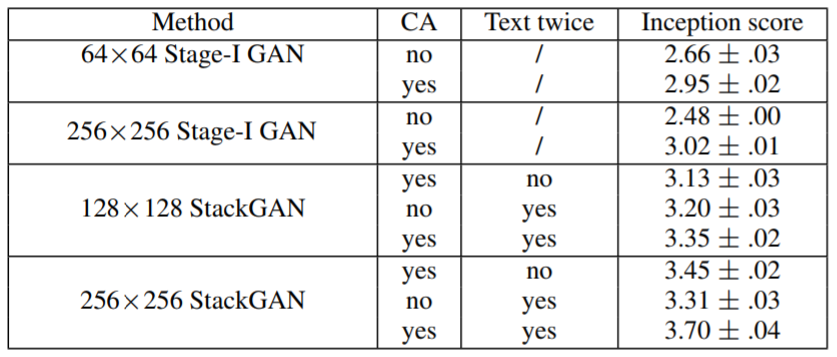

In [6]:
Image(filename = 'StackGAN_table2.PNG')

논문에서는 추가적으로 같은 StackGAN 모델에서 여러 가지 실험을 더 해보았다. 우선, 최종 output의 이미지 크기를 256$\times$256에서 128$\times$128로 줄였을 때, inception score가 감소하는 것을 확인할 수 있었고, 이는 StackGAN이 큰 이미지에서 더 세세한 정보들을 담아낸다는 것을 의미한다. 또한, 텍스트가 두 번 모두 들어갔을 때 더 높은 inception score를 보이는 것으로 보아, Stage-II GAN에 텍스트를 한 번 더 넣어주는 것이 Stage-I GAN의 결과를 보정하는데 도움 된다는 것을 알 수 있다.  
Conditioning Augmentation(CA)를 없애고 실험하였을 때는 CA가 있을 때보다 점수가 낮게 나왔고 이는 CA가 conditional GAN을 학습시키는 데 도움 된다는 것과 latent space를 연속적으로 만들어 만들어진 샘플들의 다양성을 증가시킨다는 것을 뜻한다.  
마지막으로, StackGAN의 latent space가 연속적이라는 것을 더 보여주기 위해 논문에서는 'The bird is completely red'라는 문장으로부터 'The bird is completely yellow'라는 문장이 될 때까지 noise vector $z$를 고정시키고 색깔에 대한 단어의 성분만 바꿔주면서 결과 이미지를 관찰하였다. 결과 이미지들은 그 색들의 변화를 제대로 이미지에 표현할 수 있다는 것을 보여주었다.

## Conclusion
논문에서는 텍스트로부터 이미지를 합성하는데 새로운 모델인 StackGAN을 만들었다. 이 모델은 latent space를 더 연속적이게 만들어주는 Conditioning Augmentation과 두 스텝의 GAN으로 구성되어 있다. Stage-I GAN은 이미지의 대략적인 구성과 색을, Stage-II GAN은 Stage-I GAN의 결과물을 보정하고 세밀한 정보들을 더 추가하여 더 높은 해상도의 이미지를 얻을 수 있게 해준다. 다른 두 개의 state-of-the-art 모델들에 비해 훨씬 좋은 결과를 볼 수 있엇다.